In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model,Sequential
from keras.layers import concatenate,Dropout,Flatten
from keras import optimizers
from keras.utils import to_categorical

Using TensorFlow backend.


# 数据准备

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

In [3]:
def loadData(train_file_path,file_num):
    # X.shape-->m*n
    # y.shape-->n*1
    X=np.array([])
    y=np.array([])
    for i in range(1,1+file_num):
        train_file_name=train_file_path+str(i)
        dic=unpickle(train_file_name)
        data=dic[b'data']
        labels=dic[b'labels']
        if X.shape[0]==0:
            X=data
            y=labels
        else:
            X=np.concatenate((X,data),axis=0)
            y=np.concatenate((y,labels),axis=0)
    return X,y

In [4]:
# load data
train_file_path='cifar_10_batches_py/data_batch_'
X,y=loadData(train_file_path,5)
X=X.reshape(X.shape[0],3,32,32)
X=X.transpose(0,2,3,1)
y=to_categorical(y)
print(X.shape)
print(y.shape)

(50000, 32, 32, 3)
(50000, 10)


label: 6


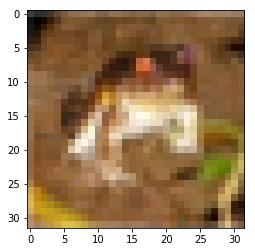

label: 9


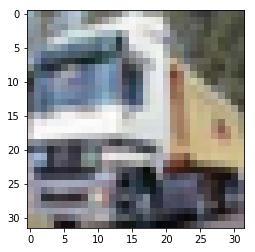

label: 9


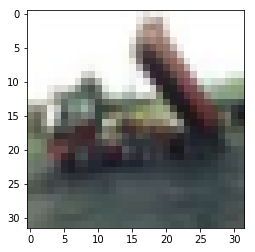

label: 4


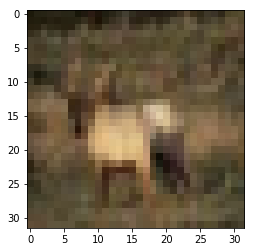

label: 1


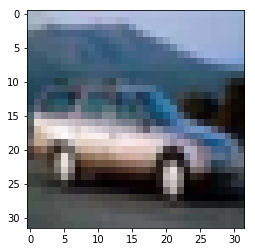

label: 1


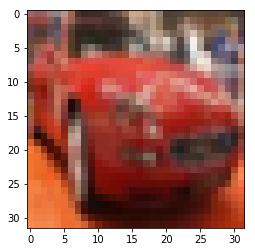

label: 2


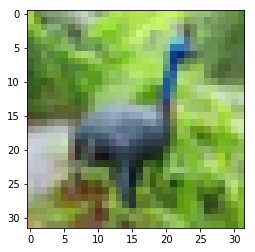

label: 7


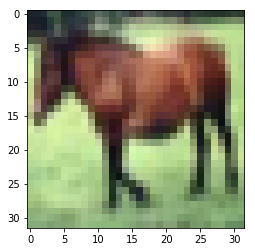

label: 8


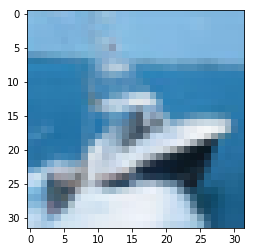

label: 3


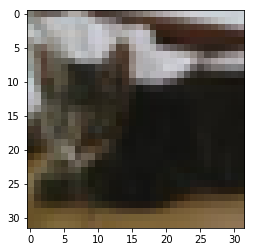

In [33]:
# show some samples
for i in range(0,10):
    img=X[i]
    print('label:',np.argmax(y[i]))
    plt.imshow(img)
    plt.show()

# 模型搭建

In [6]:
def baseCNN(input_shape=(32,32,3),output_shape=10):
    model = Sequential()
    
    model.add(Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),input_shape=input_shape,activation='relu'))    # output 29*29*16
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),activation='relu'))                          # output 27*27*32
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))                                                     # output 13*13*32
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),activation='relu'))                          # output 11*11*64
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),activation='relu'))                         # output 9*9*128
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))                                                     # output 4*4*128
            
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [8]:
base_model=baseCNN()
base_model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
print(base_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)       

# 模型训练测试

In [9]:
history=base_model.fit(X,y,batch_size=64,epochs=4,verbose=1,validation_split=0.0,shuffle=True)

Epoch 1/4
50000/50000 [==============================] - 287s 6ms/step - loss: 1.5157 - acc: 0.5011
Epoch 2/4
50000/50000 [==============================] - 291s 6ms/step - loss: 0.9242 - acc: 0.6791
Epoch 3/4
50000/50000 [==============================] - 288s 6ms/step - loss: 0.6399 - acc: 0.7799
Epoch 4/4
50000/50000 [==============================] - 287s 6ms/step - loss: 0.4188 - acc: 0.8578


In [10]:
print(history.history)

{'acc': [0.50114, 0.6791, 0.77994, 0.8578], 'loss': [1.5156846145629883, 0.9241575190353394, 0.6399036676406861, 0.41882188890457156]}


In [12]:
base_model.save('base_model.h5')

In [ ]:
#from keras.models import load_model
#model=load_model('base_model.h5')

In [14]:
def loadTestData(test_file_name):
    # X.shape-->m*n
    # y.shape-->n*1
    dic=unpickle(test_file_name)
    data=dic[b'data']
    labels=dic[b'labels']
    return data,labels

In [15]:
test_file_name='cifar_10_batches_py/test_batch'
X_test,y_test=loadTestData(test_file_name)
X_test=X_test.reshape(X_test.shape[0],3,32,32)
X_test=X_test.transpose(0,2,3,1)
y_test=to_categorical(y_test)
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 10)


In [34]:
test_result=base_model.evaluate(X_test,y_test)
for i in range(len(base_model.metrics_names)):
    print(base_model.metrics_names[i]+':'+str(test_result[i]))

10000/10000 [==============================] - 10s 982us/step
loss:1.0092433448791505
acc:0.6812999844551086


# 结果可视化

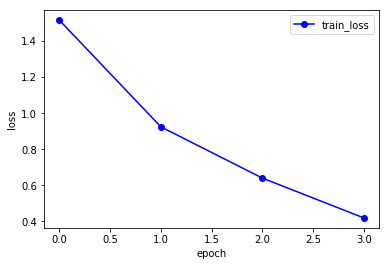

In [18]:
# visualize the training process
losses=history.history['loss']
plt.plot(losses,'bo-',label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

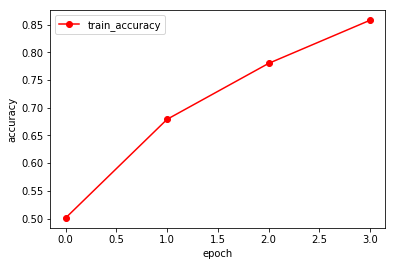

In [20]:
acces=history.history['acc']
plt.plot(acces,'ro-',label='train_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
y_pred=base_model.predict(X_test)
print(y_pred.shape)

(10000, 10)


In [30]:
from keras import backend as K
import cv2
def showCAM(img,model):
    # grad-CAM algorithm
    img_tensor=np.expand_dims(img,axis=0)
    preds=model.predict(img_tensor)
    output=model.output[:,0]
    last_conv_layer=model.get_layer('conv2d_4')
    grads=K.gradients(output,last_conv_layer.output)[0]
    pooled_grads=K.mean(grads,axis=(0,1,2))
    iterate=K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
    pooled_grads_value,conv_layer_output_value=iterate([img_tensor])
    for i in range(128):
        conv_layer_output_value[:,:,i]*=pooled_grads_value[i]
    heatmap_small=np.mean(conv_layer_output_value,axis=-1)
    heatmap_small=np.maximum(heatmap_small, 0)
    heatmap_small/=np.max(heatmap_small)
    #plt.matshow(heatmap_small)
    #plt.show()
    #img=cv2.imread(img_path)
    #img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    heatmap=cv2.resize(heatmap_small,(img.shape[0],img.shape[1]))
    plt.matshow(heatmap)
    plt.show()

predict: 3
truth: 3


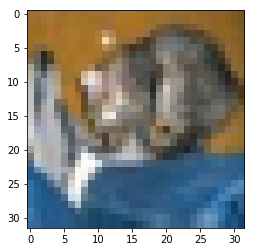

predict: 1
truth: 8


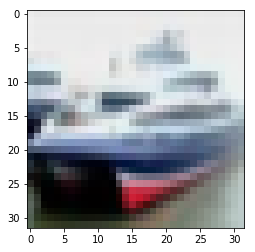

predict: 8
truth: 8


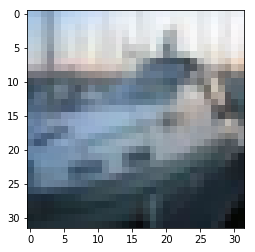

predict: 0
truth: 0


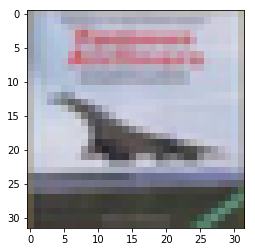

predict: 6
truth: 6


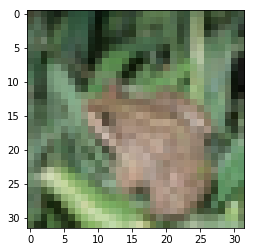

predict: 6
truth: 6


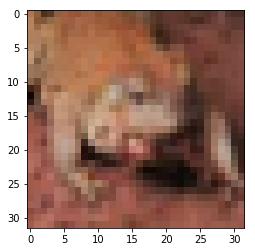

predict: 1
truth: 1


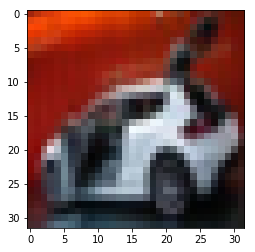

predict: 6
truth: 6


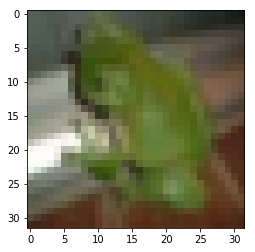

predict: 3
truth: 3


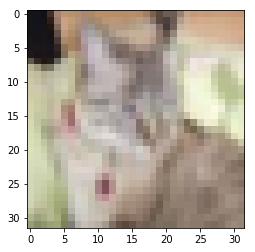

predict: 1
truth: 1


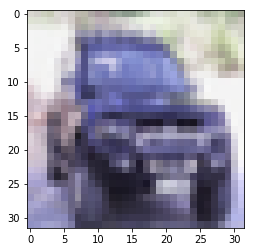

In [32]:
# show some test samples
for i in range(0,10):
    print('predict:',np.argmax(y_pred[i]))
    print('truth:',np.argmax(y_test[i]))
    #showCAM(X_test[i],base_model)
    plt.imshow(X_test[i])
    plt.show()

# 模型优化

In [7]:
def AlexNet(input_shape=(224,224,3),output_shape=10):
    model = Sequential()
    
    model.add(Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),padding='valid',input_shape=input_shape,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))

    model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))

    model.add(Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')) 

    model.add(Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_shape, activation='softmax'))
    return model